In [15]:
# CS4442 Final Project
# April 2022
# Model Implementation

In [16]:
# Reference: 
# Stuarteiffert, “Stuarteiffert/RNN-for-human-activity-recognition-using-2d-pose-input: Activity recognition from 2D pose using an LSTM RNN,” GitHub. [Online]. Available: https://github.com/stuarteiffert/RNN-for-Human-Activity-Recognition-using-2D-Pose-Input. [Accessed: 08-Apr-2022]

In [1]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf 
import time
import os

import random
from random import randint

import matplotlib
import matplotlib.pyplot as plt

from sklearn import metrics

TensorFlow 1.x selected.


In [2]:
# retrieve dataset
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/MHAD_SUBSET/
!unzip /content/drive/MyDrive/MHAD.zip -d /content/MHAD_SUBSET/

Mounted at /content/drive
Archive:  /content/drive/MyDrive/MHAD.zip
  inflating: /content/MHAD_SUBSET/X_train.txt  
  inflating: /content/MHAD_SUBSET/X_val2.txt  
  inflating: /content/MHAD_SUBSET/X_val.txt  
  inflating: /content/MHAD_SUBSET/Y_train.txt  
  inflating: /content/MHAD_SUBSET/X_test.txt  
  inflating: /content/MHAD_SUBSET/Y_test.txt  


In [3]:
# constants
CLASSES = ["JUMPING", "JUMPING_JACKS", "BOXING", "WAVING_2HANDS", "WAVING_1HAND", "CLAPPING_HANDS"]

DATA_PATH = '/content/MHAD_SUBSET/'

X_TRAIN = DATA_PATH + "X_train.txt"
X_TEST = DATA_PATH + "X_test.txt"

y_TRAIN = DATA_PATH + "Y_train.txt"
y_TEST = DATA_PATH + "Y_test.txt"

N_STEPS = 32

In [4]:
# load x and y data
# X, inputs
def loadInput(xpath):
    file = open(xpath, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / N_STEPS)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Y, labels
def loadLabels(ypath):
    file = open(ypath, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

Xtrain = loadInput(X_TRAIN)
Xtest = loadInput(X_TEST)

ytrain = loadLabels(y_TRAIN)
ytest = loadLabels(y_TEST)

print('X train: ', len(Xtrain))
print('X test: ', len(Xtest))
print('y train: ', len(ytrain))
print('y test: ', len(ytest))

X train:  22625
X test:  5751
y train:  22625
y test:  5751


In [5]:
training_iters = len(Xtrain) * 100 
batch_size = 4096
display_iter = batch_size * 8 
decaying_learning_rate = True

In [6]:
def MODEL(features, weights, bias):
    features = tf.transpose(features, [1, 0, 2])
    features = tf.reshape(features, [-1, len(Xtrain[0][0])])
    features = tf.nn.relu(tf.matmul(features, weights['hidden']) + bias['hidden'])
    features = tf.split(features, 32, 0) 

    cell1 = tf.contrib.rnn.BasicLSTMCell(34, forget_bias=1.0, state_is_tuple=True)
    cell2 = tf.contrib.rnn.BasicLSTMCell(34, forget_bias=1.0, state_is_tuple=True)
    cells = tf.contrib.rnn.MultiRNNCell([cell1, cell2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(cells, features, dtype=tf.float32)
    final_output = outputs[-1]
    return tf.matmul(final_output, weights['out']) + bias['out']

def get_batch(_train, _labels, _unsampled, batch_size):
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        _unsampled.remove(index)
    return batch_s, batch_labels, _unsampled


def onehot_encoding(y_):
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [7]:
x = tf.placeholder(tf.float32, [None, 32, len(Xtrain[0][0])])
y = tf.placeholder(tf.float32, [None, 6])

weights = {
    'hidden': tf.Variable(tf.random_normal([len(Xtrain[0][0]), 34])),
    'out': tf.Variable(tf.random_normal([34, 6], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([34])),
    'out': tf.Variable(tf.random_normal([6]))
}

pred = MODEL(x, weights, biases)

# loss
L2 = 0.0015 * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + L2
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(0.005, tf.Variable(0, trainable=False) * batch_size, 100000, 0.96, staircase=True)
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0025).minimize(cost, global_step=tf.Variable(0, trainable=False))
# acc
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred,1), tf.argmax(y,1)), tf.float32))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will al

In [8]:
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

step = 1
startime = time.time()
unsampledidx = list(range(0, len(Xtrain)))

train_loss = []
train_acc = []
test_loss = []
test_acc = []

while step * batch_size <= len(Xtrain) * 100:
    if len(unsampledidx) < batch_size: 
      unsampledidx = list(range(0, len(Xtrain)))
    batchX, labels, unsampledidx = get_batch(Xtrain, ytrain, unsampledidx, batch_size)
    batchY = onehot_encoding(labels)

    if len(batchY[0]) < 6:
      tempY = np.zeros((batch_size, 6))
      tempY[:batchY.shape[0],:batchY.shape[1]] = batchY
      batchY = tempY

    _, loss, acc = sess.run(
      [optimizer, cost, accuracy],
      feed_dict={
        x: batchX, 
        y: batchY
      }
    )
    train_loss.append(loss)
    train_acc.append(acc)
    
    if (step * batch_size % (4096 * 8) == 0) or (step == 1) or (step * batch_size > len(Xtrain) * 100):
      print(f'Iteration of {step * 4096}')
      print(f'>> Training Loss: {round(loss, 5)} - Training Accuracy: {acc}')

      loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
          x: Xtest,
          y: onehot_encoding(ytest)
        }
      )
      test_loss.append(loss)
      test_acc.append(acc)
      print(f'>> Test Loss: {round(loss)} - Test Accuracy: {acc}')
    step += 1

one_hot_predictions, accuracy, final_loss = sess.run(
  [pred, accuracy, cost],
  feed_dict={
    x: Xtest,
    y: onehot_encoding(ytest)
  }
)

test_loss.append(final_loss)
test_acc.append(accuracy)

print('--------------------------------------------------------')
print('Summary:')
print(f'>> Loss: {round(final_loss, 5)} - Accuracy: {accuracy}')
endtime = time.time()
print("Time Spent: {}".format(endtime - startime))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Iteration of 4096
>> Training Loss: 3.752579927444458 - Training Accuracy: 0.177490234375
>> Test Loss: 3 - Test Accuracy: 0.19440098106861115
Iteration of 32768
>> Training Loss: 3.089050054550171 - Training Accuracy: 0.294677734375
>> Test Loss: 3 - Test Accuracy: 0.29855677485466003
Iteration of 65536
>> Training Loss: 2.8519699573516846 - Training Accuracy: 0.401123046875
>> Test Loss: 3 - Test Accuracy: 0.4293166399002075
Iteration of 98304
>> Training Loss: 2.7591400146484375 - Training Accuracy: 0.4541015625
>> Test Loss: 3 - Test Accuracy: 0.46304991841316223
Iteration of 131072
>> Training Loss: 2.5791099071502686 - Training Accuracy: 0.513671875
>> Test Loss: 3 - Test Accuracy:

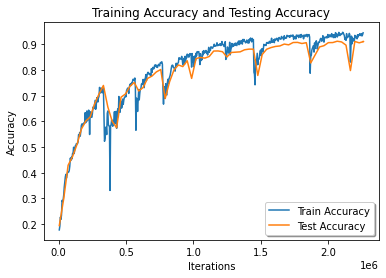

In [13]:
%matplotlib inline

trainaxis = np.array(range(batch_size, (len(train_loss) + 1) * batch_size, batch_size))
plt.plot(trainaxis, np.array(train_acc), label="Train Accuracy")

testaxis = np.append(
    np.array(range(batch_size, len(test_loss) * display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(testaxis, np.array(test_acc), label="Test Accuracy")

plt.title("Training Accuracy and Testing Accuracy")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.show()

Text(0.5, 0, 'Iterations')

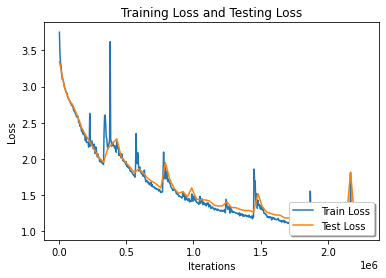

In [14]:
trainaxis = np.array(range(batch_size, (len(train_loss) + 1) * batch_size, batch_size))
plt.plot(trainaxis, np.array(train_loss), label="Train Loss")

testaxis = np.append(
    np.array(range(batch_size, len(test_loss) * display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(testaxis, np.array(test_loss), label="Test Loss")

plt.title("Training Loss and Testing Loss")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Loss')
plt.xlabel('Iterations')

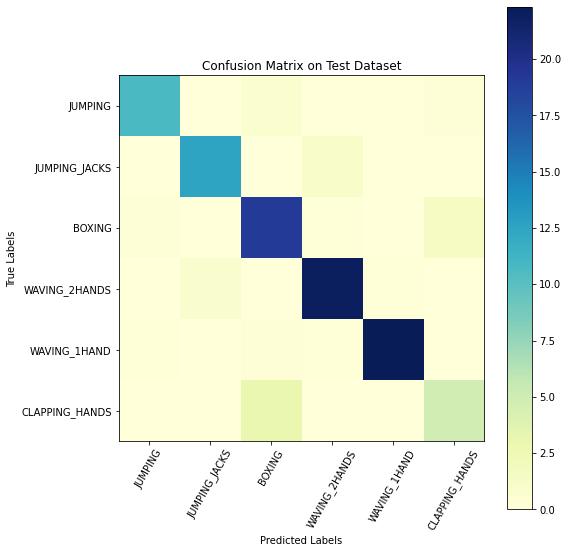

In [11]:
predictions = one_hot_predictions.argmax(1)
confusion_matrix = metrics.confusion_matrix(ytest, predictions)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100
width = 8
height = 8
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.YlGnBu
)
plt.title("Confusion Matrix on Test Dataset")
plt.colorbar()
tick_marks = np.arange(6)
plt.xticks(tick_marks, CLASSES, rotation=60)
plt.yticks(tick_marks, CLASSES)
plt.tight_layout()
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [12]:
saver = tf.train.Saver()
saver.save(sess, 'trained_model')

'trained_model'